# Run level 2A, 2B and 3 pipelines on IMA data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) Jan 30th 2019

This notebook demonstrates the execution of the level 2A, 2B and 3 pipelines for IMA data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The data files used in this notebook is a MIRISim simulation of field of point sources whose spectra are described by blackbody models.

The simulated observation is a four-point dither on the source with the F1130W filter. 

#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0500.pmap"

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'IMA_demo_data'
input_dir = 'IMA_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))
input_files = sorted(input_files)

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print("ID\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIMAGE	 F1130W	 FULL	 2	 50	 FAST	 277.5



Filename: IMA_demo_data/det_image_seq1_MIRIMAGE_F1130Wexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     114   ()      
  1  SCI           1 ImageHDU        63   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        15   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  ASDF          1 BinTableHDU     11   6544R x 1C   [B]   


#### show the last frame of the first integration for each file

/anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not found. Opening IMA_demo_data/det_image_seq1_MIRIMAGE_F1130Wexp1.fits as a MIRIRampModel
  warnings.warn(errmsg, NoTypeWarning)
/anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not found. Opening IMA_demo_data/det_image_seq2_MIRIMAGE_F1130Wexp1.fits as a MIRIRampModel
  warnings.warn(errmsg, NoTypeWarning)
/anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not found. Opening IMA_demo_data/det_image_seq3_MIRIMAGE_F1130Wexp1.fits as a MIRIRampModel
  warnings.warn(errmsg, NoTypeWarning)
/anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not fou

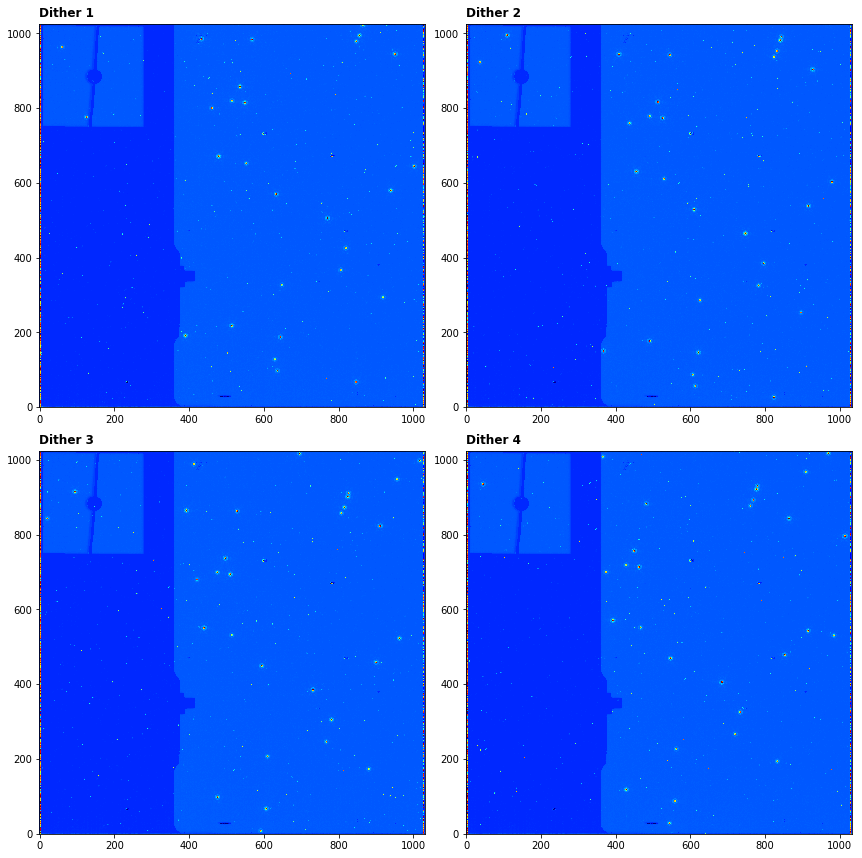

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for input_file in input_files:
    # open the input image as a jwst data model
    with datamodels.open(input_file) as in_dm:
        
        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=3e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)


    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.
    


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'. Note that we must explicitly skip the IPC step.

There is an issue currently affecting the pipelining of MIRISim data through the refpix which is being looked into. For now, we just skip this step.


In [6]:
for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'refpix': {'skip': True}})
    

2019-01-30 16:32:25,735 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-01-30 16:32:25,737 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-01-30 16:32:25,738 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-01-30 16:32:25,740 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-01-30 16:32:25,742 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-01-30 16:32:25,744 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-01-30 16:32:25,746 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-01-30 16:32:25,751 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-01-30 16:32:25,753 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-01-30 16:32:25,755 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-01-30 

2019-01-30 16:33:28,948 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.
2019-01-30 16:33:28,950 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2019-01-30 16:33:29,029 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq1_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:33:29,045 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-01-30 16:33:29,050 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2019-01-30 16:33:29,202 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2019-01-30 16:33:32,119 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-01-30 16:33:32,732 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-01-30 16:

2019-01-30 16:40:33,460 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES={} is a power of 2; correction not needed
2019-01-30 16:40:33,461 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2019-01-30 16:40:33,462 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2019-01-30 16:40:33,524 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:40:33,543 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0023.fits
2019-01-30 16:40:36,127 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-01-30 16:40:36,241 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:40:36,264 - stpipe.Detector1Pipeline.saturation - IN

2019-01-30 16:47:57,425 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2019-01-30 16:47:57,427 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-01-30 16:47:57,428 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-01-30 16:47:57,432 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-01-30 16:47:57,434 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-01-30 16:47:57,436 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-01-30 16:47:57,437 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-01-30 16:47:57,439 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2019-01-30 16:47:57,441 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2019-01-30 16:47:57,444 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance cre

2019-01-30 16:48:43,752 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq3_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:48:43,768 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-01-30 16:48:43,774 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2019-01-30 16:48:43,916 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2019-01-30 16:48:46,303 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-01-30 16:48:46,850 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-01-30 16:49:00,999 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 2
2019-01-30 16:49:17,053 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2019-01-

2019-01-30 16:56:16,527 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2019-01-30 16:56:16,529 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2019-01-30 16:56:16,586 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:56:16,605 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0023.fits
2019-01-30 16:56:19,802 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-01-30 16:56:19,961 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIMAGE_F1130Wexp1.fits>,).
2019-01-30 16:56:19,997 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0022.fit

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: None
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Image2Pipeline
print(Image2Pipeline.__doc__)


    Image2Pipeline: Processes JWST imaging-mode slope data from Level-2a to
    Level-2b.

    Included steps are:
    background_subtraction, assign_wcs, flat_field, photom and resample.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Currently MIRISim is assigning an incorret value of 4 to the wcsaxes keyword in the datamodels. This is due to issues with displaying MIRISim output in applications like ds9. However, the incorrect value will cause an error at the level 3 stage in the resample step, which expects wcsaxes=2 for images. Therefore, we manually set wcsaxes to 2 in the call to Image2Pipeline so it propagates into the cal.fits output.

In [9]:
for f in level2A_files:
    with datamodels.open(f) as dm:
        dm.meta.wcsinfo.wcsaxes = 2
        Image2Pipeline.call(dm, output_use_model=True, save_results=True, output_dir=output_dir)
    

2019-01-30 17:13:52,278 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2019-01-30 17:13:52,281 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-01-30 17:13:52,284 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-01-30 17:13:52,286 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-01-30 17:13:52,289 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2019-01-30 17:13:52,293 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2019-01-30 17:13:52,399 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-01-30 17:13:52,423 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat

2019-01-30 17:13:54,004 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits
2019-01-30 17:13:54,886 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1096, 1095)
2019-01-30 17:13:55,498 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020227987 -0.015209393 0.020227987 0.018574446 359.986474970 0.018574446 359.986474971 -0.015209393
2019-01-30 17:13:55,501 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2019-01-30 17:13:55,501 - stpipe.Image2Pipeline - INFO - Finished processing product det_image_seq4_MIRIMAGE_F1130Wexp1_rate
2019-01-30 17:13:55,510 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2
2019-01-30 17:13:55,846 - stpipe.Image2Pipeline - INFO - Saved model in IMA_demo_data_pipelined/det_image_seq4_MIRIMAGE_F1130Wexp1_cal.fits
2019-01-30 17:13:55,846 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done
20

2019-01-30 17:13:57,436 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_area_0003.fits
2019-01-30 17:13:57,437 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2019-01-30 17:13:57,438 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2019-01-30 17:13:57,438 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2019-01-30 17:13:57,439 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W
2019-01-30 17:13:57,481 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2019-01-30 17:13:57,483 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.44947
2019-01-30 17:13:57,521 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2019-01-30 17:13:57,525 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2019-01-30 17:13:57,594 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from det_image_seq3_MIR

2019-01-30 17:14:00,468 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-01-30 17:14:00,573 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-30 17:14:00,574 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-30 17:14:00,575 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-30 17:14:00,591 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-30 17:14:00,750 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2019-01-30 17:14:00,818 - stpipe.Image2Pipeline.photom - INFO - Step photom runnin

2019-01-30 17:14:03,523 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020233513 -0.018516236 0.022678273 0.012979133 359.991358973 0.015277044 359.988927849 -0.015929664
2019-01-30 17:14:03,524 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020233513 -0.018516236 0.022678273 0.012979133 359.991358973 0.015277044 359.988927849 -0.015929664
2019-01-30 17:14:03,524 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2019-01-30 17:14:03,531 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2019-01-30 17:14:03,594 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).
2019-01-30 17:14:03,675 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-30 17:14:03,676 - stpipe.Image2Pipeline.flat_field -

#### Quick check of the pipeline steps applied in the level 2B output. We'll look at the first dither:

In [10]:
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

2019-01-30 17:15:27,992 - stpipe - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/datamodels/util.py:167: NoTypeWarning: model_type not found. Opening IMA_demo_data/det_image_seq1_MIRIMAGE_F1130Wexp1.fits as a MIRIRampModel
  warnings.warn(errmsg, NoTypeWarning)



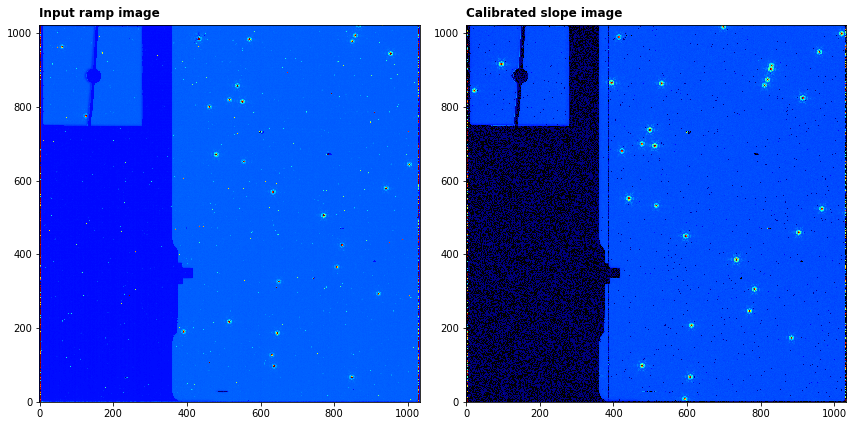

In [11]:
# open the input image as a jwst data model
with datamodels.open(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=2e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=2, vmax=100))
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

### Level 3 pipeline
We first create an association file in the output directory containing the list of level 2B files ('_cal.fits') produced by the level 2B pipeline. We can then combine the dithers with the Image3Pipeline. 

Note that we skip the skymatch step as it seems to determine a large sky background from the images which, when subtracted, results in the majority of pixels in the FOV having negative values.

The output drizzled image file will be contained in '*_i2d.fits' with the source list contained in '*_cat.ecsv'. The source detection doesn't work particularly well with default parameters so snr_threshold and source fwhm is adjusted in the call to source_catalog.


#### create the level 3 association using the asn_from_list tool

In [18]:
call(["asn_from_list", "-o", "IMA_asn.json"] + level2B_files + ["--product-name", "ima_dither"])


0

#### import the level 3 pipeline class and print description

In [19]:
from jwst.pipeline import Image3Pipeline
print(Image3Pipeline.__doc__)


    Image3Pipeline: Applies level 3 processing to imaging-mode data from
                    any JWST instrument.

    Included steps are:
        tweakreg
        skymatch
        outlier_detection
        resample
        source_catalog
    


#### run pipeline

In [20]:
dm_3_container = datamodels.ModelContainer("IMA_asn.json")

Image3Pipeline.call(dm_3_container, save_results=True, output_dir=output_dir,
                    steps={'skymatch':{'skip':True},
                           'source_catalog':{'save_results':True, 'kernel_fwhm': 5.0, 'snr_threshold': 20.}})



2019-01-30 17:21:45,332 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2019-01-30 17:21:45,334 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2019-01-30 17:21:45,338 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2019-01-30 17:21:45,341 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-01-30 17:21:45,342 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2019-01-30 17:21:45,344 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2019-01-30 17:21:45,451 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args (<ModelContainer>,).
2019-01-30 17:21:45,954 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['drizpars']
2019-01-30 17:21:45,959 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickk

2019-01-30 17:21:51,821 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2019-01-30 17:21:51,822 - stpipe.Image3Pipeline.tweakreg - WARNING - /anaconda3/envs/jwst7.2.1/lib/python3.6/site-packages/jwst-0.12.3-py3.6-macosx-10.7-x86_64.egg/jwst/tweakreg/matchutils.py:145: RuntimeWarning: invalid value encountered in double_scalars
  zpqual = flux / np.sqrt(delta_flux / delta_size)

2019-01-30 17:21:51,823 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -0.4444, -0.5185 with significance of 6.194 and 8.0 matches
2019-01-30 17:21:51,826 - stpipe.Image3Pipeline.tweakreg - INFO - Found 28 matches for 'det_image_seq2_MIRIMAGE_F1130Wexp1_cal.fits'...
2019-01-30 17:21:51,827 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'general' fit
2019-01-30 17:21:51,836 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'general' fit for det_image_seq2_MIRIMAGE_F1130Wexp1_cal.fits:
2019-01-30 17:21:51,836 - stpipe.Image3Pipeline.tweakreg

In [21]:
# move the association file to the output directory
try:
    shutil.move('IMA_asn.json',os.path.join(output_dir,'IMA_asn.json'))
except:
    pass


#### plot the drizzled file

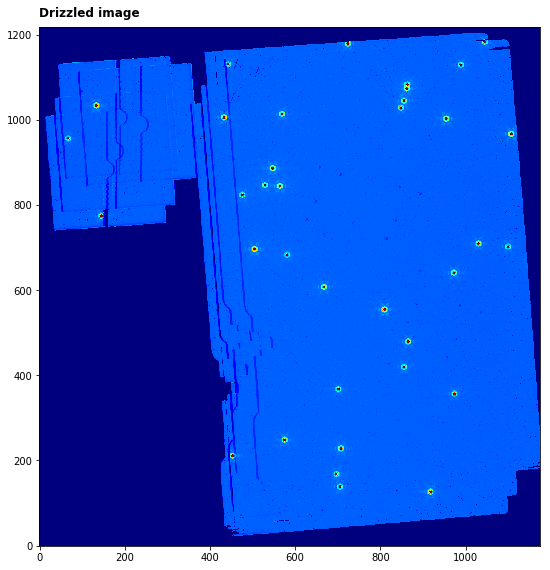

In [22]:
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0,vmax=20)
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

#### look at the source list 

In [23]:
from astropy.table import Table

my_catalog = os.path.join(output_dir,'ima_dither_cat.ecsv')
sources = Table.read(my_catalog, format='ascii.ecsv')

print(sources.columns)    # print all available column names
print()
sources['id', 'xcentroid', 'ycentroid', 'sky_centroid', 'abmag'].pprint(max_width=200)

<TableColumns names=('id','xcentroid','ycentroid','sky_centroid','area','source_sum','source_sum_err','semimajor_axis_sigma','semiminor_axis_sigma','orientation','sky_bbox_ll','sky_bbox_ul','sky_bbox_lr','sky_bbox_ur','orientation_sky','abmag','abmag_error')>

 id     xcentroid          ycentroid                      sky_centroid                      abmag       
           pix                pix                           deg,deg                                     
--- ------------------ ------------------ ------------------------------------------- ------------------
  1   917.916893484194 126.64709780768914     359.9946155047432,-0.014353176621146931 15.346123695373535
  2  705.6878441649759 138.61253066235773 0.0011573957104932349,-0.013984346286774346  15.62996768951416
  3  697.2019842741811 168.39129855601945 0.0014189695662422622,-0.013066425559332637 15.763768196105957
  4  453.5780213051416 211.72959674413556   0.00892859857818953,-0.011730536741771878 15.442553520202637
  5 

#### plot the source list over the drizzled image

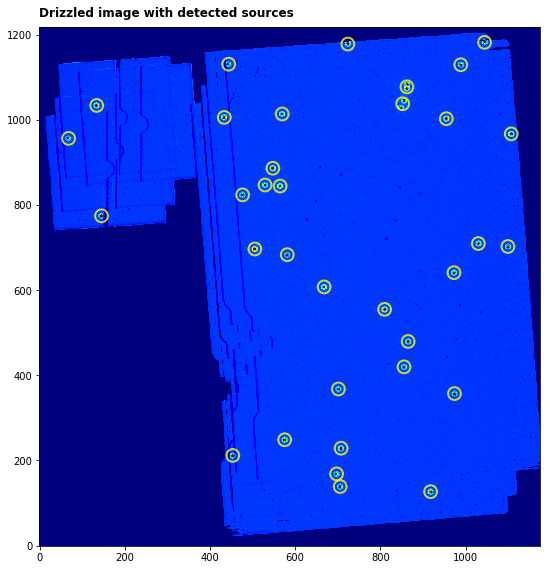

In [24]:
from astropy.table import Table
from photutils import CircularAperture

# read source X,Y positions from the table, show with circles of radius 10pix
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=15.)

# image
driz_dm = datamodels.open(os.path.join(output_dir,'ima_dither_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=1, vmax=20)
apertures.plot(color='yellow', lw=2.0, alpha=0.8)
axs.annotate('Drizzled image with detected sources', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()